In [1]:
import glob 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboardX import SummaryWriter

# import umap

import poisevae
from poisevae.datasets import MNIST_SVHN
from poisevae.networks.MNISTSVHNNetworks import EncMNIST, DecMNIST, EncSVHN, DecSVHN

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')
MNIST_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST_%s_idx.pt')
SVHN_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/SVHN_%s_idx.pt')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

# joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train', 
#                                 sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'train'), 
#                                 sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'train'))
# joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test',
#                                sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'test'), 
#                                sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'test'))

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(234, 39)

In [6]:
def mask_missing(data):
    # data: (mnist, svhn, label, label)
    rand_num = random.random()
    if rand_num < 0.2: # Send both
        return data
    elif rand_num > 0.6: # Send SVHN only
        return None, *data[1:]
    else: # Send MNIST only
        return data[0], None, *data[2:]

In [7]:
lat1, lat2 = 32, 32
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

vae = poisevae.POISEVAE_Gibbs([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                        latent_dims=[lat1, (lat2, 1, 1)], batch_size=batch_size, fix_t=True).to(device)

In [8]:
# for i in vae.named_parameters():
#     print(i[0])

In [9]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [10]:
# PATH = os.path.join('runs/MNIST_SVHN/old', datetime.now().strftime('%y%m%d%H%M'))
# PATH = os.path.join('runs/SVHN_MNIST', datetime.now().strftime('%y%m%d%H%M'))

In [11]:
epoch = 0

In [12]:
PATH = 'runs/MNIST_SVHN/test'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(PATH, 'training_10.pt'))
writer = SummaryWriter(PATH)
# writer = None

In [13]:
epochs = 20 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    poisevae.utils.test(vae, test_loader, epoch, writer)
    # if (epoch+1) % 5 == 0 and epoch > 0:
    #     poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)
    #     torch.save(vae.get_G(), os.path.join(PATH, 'G_%d.pt' % (epoch+1)))
    #     with torch.no_grad():
    #         for i, data in enumerate(test_loader):
    #             results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])
    #             torch.save(results['mu'], os.path.join(PATH, 'nu1_%d.pt' % (epoch+1)))
    #             torch.save(results['var'], os.path.join(PATH, 'nu2_%d.pt' % (epoch+1)))
    #             break

100%|█████████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.45s/it]


In [14]:
poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

In [15]:
writer.flush()
writer.close()

## Results

In [ ]:
path = 'runs/MNIST_SVHN/test'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(path, 'train*.pt')))[-1])
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_40.pt'))
epoch

### Reconstruction

In [17]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)])#, 
                      # n_gibbs_iter=30)
        break

In [18]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    # idx = torch.where(results['weights'] == results['weights'].max(dim=1).values[:, None])
    # x_rec = [x_rec[0].loc[idx], x_rec[1].loc[idx]] # (batch, IW samples, ...)

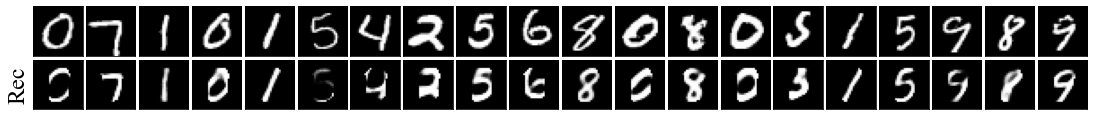

In [19]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

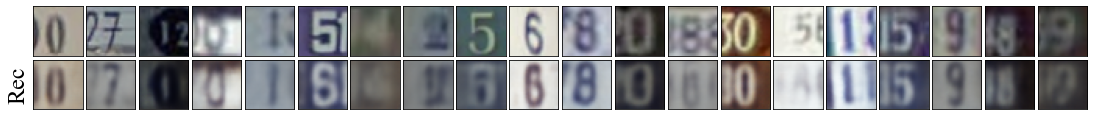

In [20]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Cross Generation

#### MNIST -> SVHN

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), None], n_gibbs_iter=100)
        break

In [ ]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

In [ ]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

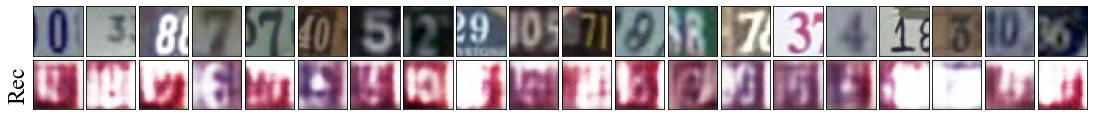

In [29]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

#### MNIST <- SVHN

In [30]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([None, data[1].to(device, dtype=torch.float32)], n_gibbs_iter=100)
        break

In [31]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

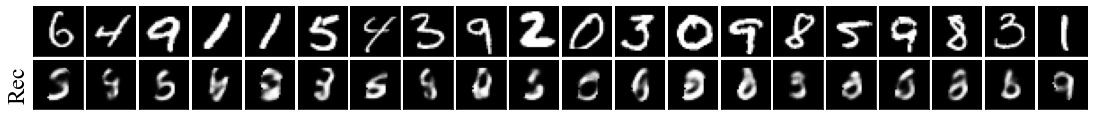

In [32]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

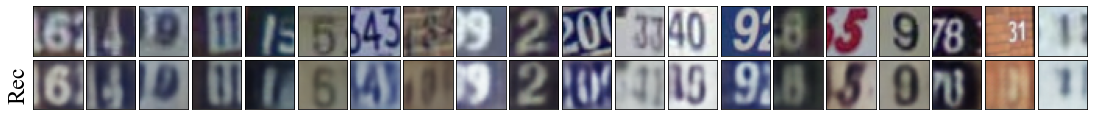

In [33]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Joint Generation

In [34]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([None, None], n_gibbs_iter=100)
        break

In [35]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

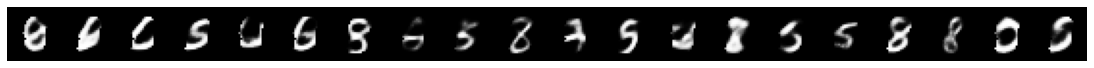

In [36]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[0]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

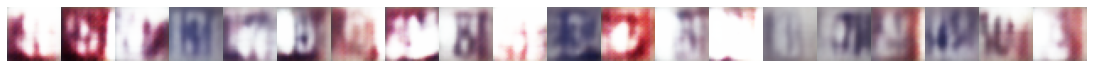

In [37]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(15, 0.75))
for i, im in enumerate(x_rec[1]):
    if i >= ncols:
        break
    ax[i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    ax[i].set_axis_off()
# ax[0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

## Latent Space Analysis

In [ ]:
batch_size = 3000
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

In [ ]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        label = data[-1].detach().cpu().numpy()
        data = [data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)]
        results = vae([data[0], data[1]], n_gibbs_iter=50)

        reducer = umap.UMAP(min_dist=0.01, n_neighbors=30)
        embedding = reducer.fit_transform(results['z'][0].detach().cpu().numpy())
        break
    for k in range(0, 10):
        plt.scatter(*embedding[label==k].T, c='C%d' % k, s=2)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
path = 'runs/MNIST_SVHN/2201240015/'
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_80.pt'))
epoch

In [ ]:
umap_projs = {'condition': [], 'num Gibbs samples': [], 'embeddings': [], 'labels': []}

num_gibbs_s = [5, 20, 100]
with torch.no_grad():
    for i, data in enumerate(test_loader):
        label = data[-1].detach().cpu().numpy()
        data = [data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)]
        
        for i, num_gibbs in enumerate(num_gibbs_s):
            for j, (cond, data_) in enumerate(zip(('Rec', 'Joint', 'M2S', 'S2M'), 
                                                  (data, [None, None], [data[0], None], [None, data[1]]))):
                results = vae(data_, n_gibbs_iter=num_gibbs)
                
                reducer = umap.UMAP(min_dist=0.01, n_neighbors=50)
                embedding = reducer.fit_transform(results['z'][0].detach().cpu().numpy())
                
                umap_projs['condition'].append(cond)
                umap_projs['num Gibbs samples'].append(num_gibbs)
                umap_projs['embeddings'].append(embedding)
                umap_projs['labels'].append(label)
        break

In [ ]:
umap_projs_df = pd.DataFrame(umap_projs)

In [ ]:
def plot(embedding, label, color=None, *args):
    embedding = embedding.iloc[0]
    label = label.iloc[0]
    for k in range(0, 10):
        plt.scatter(*embedding[label==k].T, c='C%d' % k, s=1)

g = sns.FacetGrid(umap_projs_df, col='condition', row='num Gibbs samples', sharex=False, sharey=False, margin_titles=True, height=3.5)
g.map(plot, 'embeddings', 'labels')

In [ ]:
path = 'runs/MNIST_SVHN/2201240015/'
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_30.pt'))
epoch

In [ ]:
epochs = (30, 40, 50)#, 60, 70, 80)
paths = glob.glob('runs/MNIST_SVHN/old/22*')
fig, ax = plt.subplots(ncols=len(epochs), nrows=len(paths), figsize=(len(epochs)*3, len(paths)*2))
if len(paths) == 1:
    ax = ax[None, :]
    G = 0
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        G_ = vae.get_G().detach().cpu().numpy()#.clip(min=-100, max=100)
        im = ax[i, j].imshow(G_ - G)
        G = G_
        fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_axis_off()
fig.tight_layout(pad=0)

In [ ]:
epochs = (30, 40, 50)#, 60, 70, 80)
# paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=len(epochs), nrows=len(paths), figsize=(len(epochs)*2, len(paths)*2))
if len(paths) == 1:
    ax = ax[None, :]
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        G = np.zeros(vae.get_G().detach().cpu().numpy().shape)
        g12_hat = vae.g12_hat.detach().cpu().numpy()
        g21_hat = vae.g21_hat.detach().cpu().numpy()
        G[:g12_hat.shape[0], g12_hat.shape[1]:] = g12_hat
        G[g21_hat.shape[0]:, :g21_hat.shape[1]] = g21_hat
        im = ax[i, j].imshow(np.abs(np.tanh(G)) < 0.8)
        # fig.colorbar(im, ax=ax[i, j])
        ax[i, j].set_axis_off()
fig.tight_layout(pad=0.1)

In [ ]:
epochs = (30, 40, 50, 60, 70, 80)
paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=2, nrows=len(paths), figsize=(8, len(paths)*1), sharex='col')
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        t1 = vae.get_t()[0]
        im = ax[i, 0].plot(t1[0].detach().cpu().numpy(), c='r', alpha=0.2+j*0.8/len(epochs))
        im = ax[i, 1].plot(t1[1].detach().cpu().numpy(), c='g', alpha=0.2+j*0.8/len(epochs))
fig.tight_layout(pad=0)

In [ ]:
epochs = (30, 40, 50, 60, 70, 80)
paths = glob.glob('runs/MNIST_SVHN/22*')
fig, ax = plt.subplots(ncols=2, nrows=len(paths), figsize=(8, len(paths)*1), sharex='col')
for i, path in enumerate(paths):
    for j, t in enumerate(epochs):
        vae, _, _ = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_%d.pt'%t))
        t2 = vae.get_t()[1]
        im = ax[i, 0].plot(np.log(-t2[0].detach().cpu().numpy()), c='r', alpha=0.2+j*0.8/len(epochs))
        im = ax[i, 1].plot(np.log(-t2[1].detach().cpu().numpy()), c='g', alpha=0.2+j*0.8/len(epochs))
fig.tight_layout(pad=0)